In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel
import os
from pathlib import Path
import numpy as np

In [3]:
from mri import MRI

/home/cure/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
from bids_utils import BIDSDatabase
database = BIDSDatabase('bids/', 'results/')

In [5]:
res = database.get_all_func()

In [6]:
import pandas
import nilearn
from nilearn.image import index_img, concat_imgs

In [123]:
repetition_time = 2.39951

def get_svc_data(subjects, runs=range(0,4), mode='stim_vs_all'):

    global_data = {}
    
    for group, subject in enumerate(subjects):

        labels = pandas.read_csv(f'labels/labels_{subject}.csv')
        data = {}

        for run in runs:
            mask = labels['run'] == run + 1
            run_labels = labels[mask]

            times = np.around((run_labels['run time'].values + lag)/ (1000*repetition_time)).astype(int)
            if mode == 'stim_vs_all':
                all_times = np.arange(res['%02d' %subject][run].shape[3])
                responses = np.in1d(all_times, times).astype(int)
            elif mode == 'human_responses':
                all_times = times
                responses = run_labels['response'].values

            data[run] = {'nii' : index_img(res['%02d' %subject][run].preprocessed, all_times), 
                         'labels' : responses,
                         'groups' : group * np.ones(len(responses))}
        
        run_volumes = concat_imgs([data[i]['nii'] for i in runs])
        run_labels = np.concatenate([data[i]['labels'] for i in runs])
        groups = np.concatenate([data[i]['groups'] for i in runs])
        mask = res['%02d' %subject][0].brain_mask
                    
        if not 'nii' in global_data:
            global_data = {'nii' : run_volumes, 
                           'labels' : run_labels, 
                           'groups' : groups, 
                           'mask' : mask}

        else:
            global_data['nii'] = concat_imgs([global_data['nii'], run_volumes])
            global_data['labels'] = np.concatenate([global_data['labels'], run_labels])
            global_data['groups'] = np.concatenate([global_data['groups'], groups])
            
    return global_data

In [129]:
global_data = get_svc_data(range(2, 5), mode='stim_vs_all')

In [130]:
global_data['nii'].shape

(65, 77, 55, 2448)

In [131]:
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

from nilearn.decoding import Decoder
from sklearn.svm import LinearSVC

decoder = Decoder(
    estimator='svc',
    mask=global_data['mask'],
    smoothing_fwhm=4,
    standardize=True,
    screening_percentile=5,
    scoring="roc_auc",
    cv = cv,
    n_jobs=-1
)
    
decoder.fit(global_data['nii'], global_data['labels'], groups=global_data['groups'])
print(decoder.cv_scores_[0])
print(decoder.cv_scores_[1])

/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fail

[0.5652552926525529, 0.5253318348874646, 0.5793001852808067]
[0.5652552926525529, 0.5253318348874646, 0.5793001852808067]


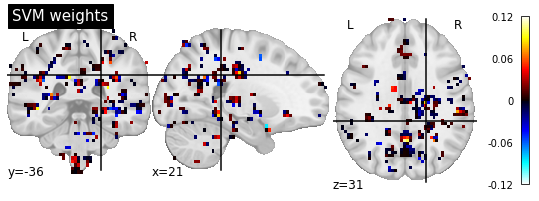

In [127]:
weight_img = decoder.coef_img_[0]
from nilearn.plotting import plot_stat_map, show

plot_stat_map(weight_img, title="SVM weights")

show()

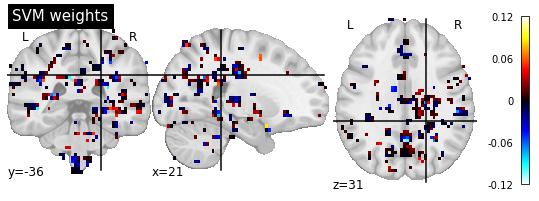

In [128]:
weight_img = decoder.coef_img_[1]
from nilearn.plotting import plot_stat_map, show

plot_stat_map(weight_img, title="SVM weights")

show()

/home/cure/anaconda3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7efecfa07a90>)


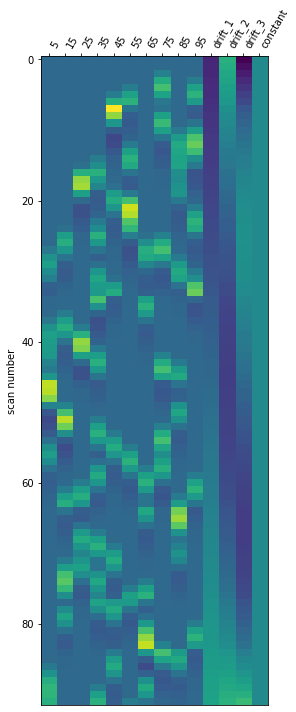

In [166]:
repetition_time = 2.39951

global_data = {}
    
subject = 1
mode = 'human_responses'
labels = pandas.read_csv(f'labels/labels_{subject}.csv')
data = {}

for run in [1]:
    mask = labels['run'] == run + 1
    run_labels = labels[mask]

    times = np.around((run_labels['run time'].values + lag)/ (1000*repetition_time)).astype(int)
    conditions = run_labels['morph level']
    if mode == 'stim_vs_all':
        all_times = np.arange(res['%02d' %subject][run].shape[3])
        responses = np.in1d(all_times, times).astype(int)
    elif mode == 'human_responses':
        all_times = times
        responses = run_labels['response'].values

    from nilearn.glm.first_level import make_first_level_design_matrix

    import pandas as pd

    events = pd.DataFrame(
        {"trial_type": conditions, "onset": times, "duration": 5}
    )
    
    design_matrices = make_first_level_design_matrix(times, events,
                              drift_model='polynomial', drift_order=3)
    
    from nilearn.plotting import plot_design_matrix
    plot_design_matrix(design_matrices)
    
    data[run] = {'nii' : index_img(res['%02d' %subject][run].preprocessed, all_times), 
                         'labels' : responses,
                         'groups' : np.ones(len(responses))}
    
    from nilearn.glm.first_level import FirstLevelModel
    fmri_glm = FirstLevelModel(mask_img = res['%02d' %subject][run].brain_mask)
    fmri_glm = fmri_glm.fit(data[run]['nii'], design_matrices=design_matrices)
    print(fmri_glm)

In [183]:
conditions = events.trial_type.unique()
for e in conditions:
    print(e)
    fmri_glm.compute_contrast([75])

75


IndexError: tuple index out of range

In [180]:
fmri_glm.compute_contrast(events['trial_type'] == 5)

ValueError: contrast_def must be an array or str or list of (array or str)